# Trash Detection Model V2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/trash_detection')

## Get Inputs

In [3]:
trainKeys = []
f = open("trainKeys.txt", "r")
for l in f.readlines():
    trainKeys.append(l[:-1])
f.close()

testKeys = []
f = open("testKeys.txt", "r")
for l in f.readlines():
    testKeys.append(l[:-1])
f.close()

len(trainKeys), len(testKeys)

(1200, 300)

In [4]:
import json
import numpy as np

f = open("imgAnn4_output_json_yolov1_224_v2.json")
imgAnn4_output = json.load(f)
f.close()

for k in imgAnn4_output:
    imgAnn4_output[k] = np.array(imgAnn4_output[k])

In [5]:
imgAnn4_output[k].shape

(7, 7, 65)

In [6]:
imgAnn4_input = {}

import h5py

f = h5py.File("taco_imgFeat_vgg16.h5")
for k in list(f.keys()):
    imgAnn4_input[k] = np.array(f[k])
f.close()

## Model Definition

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, Reshape, Concatenate, Flatten, \
                                    Dense, LeakyReLU, BatchNormalization, Layer, ReLU, Dropout
import tensorflow.keras.backend as K
import numpy as np

In [8]:
num_classes = 60
batch_size = 32
inp_dim = 224

In [9]:
idx_p = [0]
idx_bb = [1, 2, 3, 4]
idx_cls = [i for i in range(5,5+num_classes)]

@tf.function
def loss_bb(y_true, y_pred):
    y_true = tf.gather(y_true, idx_bb, axis=-1)
    y_pred = tf.gather(y_pred, idx_bb, axis=-1)

    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.reduce_mean(loss[loss > 0.0])

@tf.function
def loss_p(y_true, y_pred):
    y_true = tf.gather(y_true, idx_p, axis=-1)
    y_pred = tf.gather(y_pred, idx_p, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_cls(y_true, y_pred):
    y_true = tf.gather(y_true, idx_cls, axis=-1)
    y_pred = tf.gather(y_pred, idx_cls, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_func(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred) + loss_cls(y_true, y_pred)

In [10]:
def modelDef():
    x = x_input = Input(shape=(7, 7, 512))

    # x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    # x = MaxPool2D()(x)
    # x = BatchNormalization()(x) # size: 64x64

    # x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    # x = BatchNormalization()(x)  # size: 64x64

    # x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    # x = MaxPool2D()(x)
    # x = BatchNormalization()(x)  # size: 32x32

    # x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    # x = MaxPool2D()(x)
    # x = BatchNormalization()(x)  # size: 16x16

    # x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    # x = MaxPool2D()(x)
    # x = BatchNormalization()(x) # size: 8x8x

    # ---

    x_prob = Conv2D(1, kernel_size=3, padding='same', activation='sigmoid', name='x_prob')(x)
    x_boxes = Conv2D(4, kernel_size=3, padding='same', name='x_boxes')(x)
    x_cls = Conv2D(num_classes, kernel_size=3, padding='same', activation='sigmoid', name='x_cls')(x)

    # ---

    gate = tf.where(x_prob > 0.5, tf.ones_like(x_prob), tf.zeros_like(x_prob))
    x_boxes = x_boxes * gate
    x_cls = x_cls * gate

    # ---

    x = Concatenate()([x_prob, x_boxes, x_cls])

    model = tf.keras.models.Model(x_input, x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.003)
    model.compile(loss=loss_func, optimizer=opt)
    
    return model

model = modelDef()
print(model.summary())
del model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 7, 512)]  0           []                               
                                                                                                  
 x_prob (Conv2D)                (None, 7, 7, 1)      4609        ['input_1[0][0]']                
                                                                                                  
 tf.math.greater (TFOpLambda)   (None, 7, 7, 1)      0           ['x_prob[0][0]']                 
                                                                                                  
 tf.ones_like (TFOpLambda)      (None, 7, 7, 1)      0           ['x_prob[0][0]']                 
                                                                                              

## Dataloader function

In [15]:
import random
import cv2

def dataGenerator(modelOutput, keys, isRandom=True):
    keys_copy = keys.copy()
    modelOutput_copy = modelOutput.copy()

    if isRandom:
        random.shuffle(keys_copy)

    i = 0
    while True:
        if i + batch_size <= len(keys_copy):
            reqKeys = keys_copy[i:i+batch_size]

            # images = [cv2.imread("./data/"+k) for k in reqKeys]
            # images = [cv2.resize(image, (inp_dim, inp_dim)) for image in images]
            # images = np.array(images, dtype='float32')/255.

            images = [imgAnn4_input[k.replace("/", "_")] for k in reqKeys]
            images = np.array(images, dtype='float32')
            images = np.squeeze(images)

            out = np.array([modelOutput_copy[k] for k in reqKeys])

            yield images, out
            i+=batch_size
        else:
            i= 0
            continue

In [16]:
x = next(dataGenerator(imgAnn4_output, trainKeys))
print(x[0].shape, x[1].shape)
del x

(32, 7, 7, 512) (32, 7, 7, 65)


## Training

In [22]:
def getBBoxes(yt, yp, threshold):
    bboxes = []
    for i in range(yt.shape[0]):
        for j in range(yt.shape[1]):
            if yt[i][j][0] >= threshold and yp[i][j][0] >= threshold:
                bboxes.append([yt[i][j][1:5], yp[i][j][1:5]])

    return bboxes

def getIoUOneBox(bb1, bb2):
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2]+bb1[0], bb2[2]+bb2[0])
    y_bottom = min(bb1[3]+bb1[1], bb2[3]+bb2[1])

    if x_right < x_left or y_bottom < y_top:
        return 0.0
        
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    bb1_area = (bb1[2]) * (bb1[3])
    bb2_area = (bb2[2]) * (bb2[3])
    
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    if iou < 0:
        return 0
    if iou > 1:
        return 1
    return iou

def getIouMultipleBoxes(bboxes):
    iou = 0
    for bb in bboxes:
        box1 = bb[0]
        box2 = bb[1]
        iou += getIoUOneBox(box1, box2)
    if len(bboxes) == 0:
        return 0
    return iou/len(bboxes)

def getIoU(y_pred, testKeys, threshold = 0.5):
    reqOut = [imgAnn4_output[k] for k in testKeys[:len(y_pred)]]

    iouScores = []
    for i in range(len(reqOut)):
        bboxes = getBBoxes(reqOut[i], y_pred[i], threshold)
        iouScores.append(getIouMultipleBoxes(bboxes))

    return sum(iouScores)/len(iouScores)

In [ ]:
model = modelDef()
model.load_weights("model_yolo1_224.h5")

currIou = 2.0226033998795684e-05

for e in range(1000):
    history = model.fit(x=dataGenerator(imgAnn4_output, trainKeys),
                        steps_per_epoch=int(len(trainKeys) / batch_size),
                        epochs=1,
                        verbose=1)
    y_pred = model.predict(x=dataGenerator(imgAnn4_output, testKeys, isRandom=False),
                      steps=1,
                      verbose=1,
                      batch_size=batch_size)
    
    iou = getIoU(y_pred, testKeys)
    print("Epoch:",e+1,"\tIOU:",iou)
    
    if iou > currIou:
        model.save_weights("model_yolo1_224.h5")

## Prediction

In [26]:
from matplotlib import pyplot as plt
def drawBoundingBox(fname, bboxes, output_shape=None, showGrid=False):
    imgFile = "./data/"+fname

    image = cv2.imread(imgFile)

    if output_shape is not None:
        image = cv2.resize(image, output_shape)

    for bbox in bboxes:
        start_point = (int(bbox[0]), int(bbox[1]))
        end_point = (int(bbox[0])+int(bbox[2]), int(bbox[1])+int(bbox[3]))
        color = (255, 0, 0)
        thickness = 2

        cx = int(bbox[0] + (bbox[2]/2))
        cy = int(bbox[1] + (bbox[3]/2))
        
        image = cv2.rectangle(image, start_point, end_point, color, thickness)
        image = cv2.circle(image, (cx,cy), 3, color, thickness)

    if showGrid:
        for i in range(32):
            sp = (int(i*inp_dim/32),0)
            ep = (int(i*inp_dim/32),inp_dim)
            image = cv2.line(image, sp, ep, (0, 255, 0), thickness) 

            sp = (0,int(i*inp_dim/32))
            ep = (inp_dim,int(i*inp_dim/32))
            image = cv2.line(image, sp, ep, (0, 255, 0), thickness)

    plt.imshow(image)
    plt.show()

In [27]:
# model = modelDef()
# model.load_weights("model.h5")

y_pred = model.predict(x=dataGenerator(imgAnn4_output, testKeys, isRandom=False),
                      steps=1,
                      verbose=1)

1/1 [==============================] - 0s 343ms/step


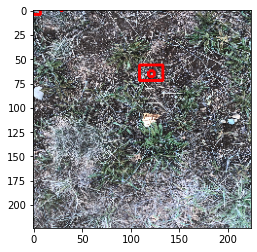

In [40]:
index = random.randint(0,y_pred.shape[0]-1)
fname = testKeys[index]

out = y_pred[index]

bboxes = []

for i in range(7):
    for j in range(7):
        if out[i][j][0] >= 0.5:
            bb = []

            x = out[i][j][1]
            y = out[i][j][2]
            w = out[i][j][3]
            h = out[i][j][4]
            
            bboxes.append([x,y,w,h])     

len(bboxes)     

drawBoundingBox(fname, bboxes, output_shape=(inp_dim,inp_dim))